In [141]:
using LinearAlgebra
using Random
using Distributions
using ProgressMeter
using Statistics  

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions


using NLopt

using Plots
using StatsPlots  
using Distributions
using DataFrames

In [142]:
function state_space(params)
    # Unpack parameters
    psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1,
    sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = params
    

    # State vector dimensions u_t B_t c_t c_t-1
    state_dim = 4

    

    # Observation matrix Z
    Z = zeros(state_dim)
    Z[1] = 1
    Z[end - 1] = 1

    # Innovation covariance matrix H
    H = 0

    # Transition matrix T
    T = zeros(state_dim, state_dim)
    T[1, 1] = 1  # u_t = u_{t-1} + beta_{t-1}
    T[1, 2] = 1
    T[2, 2] = 1  # beta_t = beta_{t-1} + xi_t
    T[3, 3] = psi1 # c_t = psi1 * c_{t-1} + psi2 * c_{t-2} + kappa_t
    T[3,4] = psi2 
    T[4, 3] = 1  #c_t-1 = c_{t}


    # State loading matrix R
    R = zeros(state_dim, state_dim)
    R[1, 1] = 1  # u_t = u_{t-1} + beta_{t-1} + epsilon_t
    R[2, 2] = 1  # beta_t = beta_{t-1} + xi_t
    R[3,3] = 1  

    # Process covariance matrices Q_0 and Q_1
    Q_0 = zeros(state_dim, state_dim)
    Q_0[1, 1] = sigma_epsilon2_0
    Q_0[2, 2] = sigma_xi2
    Q_0[3, 3] = sigma_kappa2_0 

    Q_1 = zeros(state_dim, state_dim)
    Q_1[1, 1] = sigma_epsilon2_1
    Q_1[2, 2] = sigma_xi2
    Q_1[3, 3] = sigma_kappa2_1 

    nu0 = zeros(state_dim)
    nu1 = zeros(state_dim)

    nu1[3] = omega
    

    return Z, H, T, R, Q_0, Q_1, nu0, nu1
end


state_space (generic function with 1 method)

In [143]:
function simulate_data(params, n_obs, alpha_init)
    Z, H, T, R, Q_0, Q_1, nu0, nu1 = state_space(params)
    
    psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1,
    sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = params

    state_dim = 4

    # Initialize state and observation vectors
    alpha = zeros(n_obs, state_dim)
    y = zeros(n_obs)
    # Initialize S_t
    S = zeros(Int, n_obs)

    # Initial state for S
    prob_S0 = [(1 - p) / (2 - p - q), (1 - q) / (2 - p - q)]
    S[1] = rand(Categorical(prob_S0))-1 #S is 0 or 1
    
    v = zeros(state_dim)
    if S[1] == 1  #Recesion
        # v = rand(MvNormal(zeros(state_dim), Q_1)) + nu1
        v[1] = rand(Normal(0, sqrt(params[7])))
        v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
        v[3] = rand(Normal(0, sqrt(params[5]))) #sigma kappa
        v = v + nu1
    else
        # v = rand(MvNormal(zeros(state_dim), Q_0)) + nu0
        v[1] = rand(Normal(0, sqrt(params[6]))) # sigma_epsilon
        v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
        v[3] = rand(Normal(0, sqrt(params[4]))) #sigma kappa
        v = v + nu0
    end
    alpha[1, :] = alpha_init + R * v
    y[1] = Z' * alpha[1, :] 

    # Simulate forwards
    for t in 2:n_obs
        if S[t - 1] == 1
            S[t] = rand(Categorical([1-p, p]))-1
        else
            S[t] = rand(Categorical([q, 1-q]))-1
        end

        v = zeros(state_dim)
        if S[t] == 1 #Recesion
            # v = rand(MvNormal(zeros(state_dim), Q_1)) + nu1
            v[1] = rand(Normal(0, sqrt(params[7]))) #sigma epsilon
            v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
            v[3] = rand(Normal(0, sqrt(params[5]))) #sigma kappa
            v = v + nu1

        else
            # v = rand(MvNormal(zeros(state_dim), Q_0)) + nu0
            v[1] = rand(Normal(0, sqrt(params[6]))) # sigma_epsilon
            v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
            v[3] = rand(Normal(0, sqrt(params[4]))) #sigma kappa
            v = v + nu0
     

        end

        alpha[t, :] = T * alpha[t - 1, :] + R * v
        y[t] = Z' * alpha[t, :] 
    end

    return y, alpha
end

simulate_data (generic function with 1 method)

In [166]:
function switching_kalman_filter(y, params, a1, P1)

    Z, H, T, R, Q0, Q1, nu0, nu1 = state_space(params)
    Q = [Q0, Q1]
    nu = [nu0, nu1]
    n = length(y)
    state_dim = 4

    # Initialize log-likelihood and initial state
    L = 0.0
    a_prev = zeros(2, state_dim)
    a_prev[1, :] = a1
    a_prev[2, :] = a1

    P_prev = zeros(2, state_dim, state_dim)
    P_prev[1, :, :] = P1
    P_prev[2, :, :] = P1

    # Initial probabilities
    p_S_ohm_prev = [(1 - p) / (2 - p - q), (1 - q) / (2 - p - q)]

    # Corrected definition of p_S_S
    p_S_S = zeros(2, 2)
    p_S_S[1, 1] = q # prob s = 0 given s = 0
    p_S_S[1, 2] = 1 - q # prob s = 1 given s = 0
    p_S_S[2, 1] = 1-p # prob s =0 given s = 1
    p_S_S[2, 2] = p # prob s = 1 given s = 1
    # List to store estimated states
    a_est_list = []

    S = [1, 2]  # Possible state index

    for t in 1:n
        # Initialize variables for current time step
        a_pred = zeros(2,2, state_dim)
        P_pred = zeros(2, 2, state_dim, state_dim)
        a_filt = zeros(2, 2, state_dim)
        P_filt = zeros(2, 2, state_dim, state_dim)
        v = zeros(2,2)
        F = zeros(2, 2)
        K = zeros(2, 2, state_dim)
        p_y_S_S_ohm = zeros(2, 2)
    

        for i in S
            for j in S
                # Prediction step
                a_pred_i_j = T * a_prev[i, :] + nu[j]
                P_prev_i = reshape(P_prev[i, :, :], state_dim, state_dim)
                P_pred_i_j = T * P_prev_i * T' + R * Q[j] * R'

                # Observation prediction
                y_pred = Z' * a_pred_i_j

                # Prediction error (innovation)
                v_i_j = y[t] - y_pred

                # Prediction error variance
                F_i_j = Z' * P_pred_i_j * Z + H

                # Kalman gain
                K_i_j = (P_pred_i_j * Z) / F_i_j  # Shape: (state_dim,)

                # Update state estimate
                a_filt_i_j = a_pred_i_j + K_i_j * v_i_j

                # Update covariance estimate
                P_filt_i_j = (I(state_dim) - K_i_j * Z') * P_pred_i_j

                # Store results
                a_pred[i,j, :] = a_pred_i_j
                P_pred[i, j, :, :] = P_pred_i_j
                a_filt[i, j, :] = a_filt_i_j
                P_filt[i, j, :, :] = P_filt_i_j
                v[i,j] = v_i_j
                F[i, j] = F_i_j
                K[i, j, :] = K_i_j

                # Compute p(y_t | S_{t-1}=i, S_t=j, Ψ_{t-1})
                p_y_S_S_ohm[i, j] = (1 / sqrt(2 * π * F[i,j])) * exp(-0.5 * v[i,j]^2 / F[i,j])
            end
        end


        # Compute p(y_t | Ψ_{t-1})
        p_S_S_ohm_prev = zeros(2, 2)
        for i in S
            for j in S
                p_S_S_ohm_prev[i, j] = p_S_ohm_prev[i] * p_S_S[i, j]
            end
        end

        p_y_ohm_t = sum(p_S_S_ohm_prev .* p_y_S_S_ohm)
        L += log(p_y_ohm_t)

        # Update probabilities
        p_S_S_ohm_t = (p_S_S_ohm_prev .* p_y_S_S_ohm) / p_y_ohm_t
        p_S_ohm_t = vec(sum(p_S_S_ohm_t, dims=1))

        # Combine filtered estimates
        a_t = zeros(2, state_dim)
        P_t = zeros(2, state_dim, state_dim)

        for j in S
            numerator_a = zeros(state_dim)
            denominator = p_S_ohm_t[j]
            for i in S
                numerator_a += p_S_S_ohm_t[i, j] * a_filt[i, j, :]
            end
            a_t_j = numerator_a / denominator
            a_t[j, :] = a_t_j

            numerator_P = zeros(state_dim, state_dim)
            for i in S
                diff = a_t_j - a_filt[i, j, :]
                P_filt_i_j = reshape(P_filt[i, j, :, :], state_dim, state_dim)
                numerator_P += p_S_S_ohm_t[i, j] * (P_filt_i_j + diff * diff')
            end
            P_t[j, :, :] = numerator_P / denominator
        end

        # Estimate state
        a_est_t = zeros(state_dim)
        for j in S
            a_est_t += p_S_ohm_t[j] * a_t[j, :]
        end
        push!(a_est_list, a_est_t)

        # Prepare for next iteration
        a_prev = a_t
        P_prev = P_t
        p_S_ohm_prev = p_S_ohm_t
    end

    # Convert a_est_list to array
    a_est = hcat(a_est_list...)'  # Each row corresponds to a time step
    return L, a_est
end


switching_kalman_filter (generic function with 2 methods)

In [167]:
# Define initial state and covariance

state_dim = 4
alpha_init = zeros(state_dim)
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

# True parameters for simulation
psi1 = 0.6
psi2 = 0.2
sigma_xi2 = 0.5
sigma_kappa2_0 = 0.9
sigma_kappa2_1 = 0.4
sigma_epsilon2_0 = 0.7
sigma_epsilon2_1 = 0.2
omega = -0.2
p = 0.2
q = 0.7
params_true = [psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q]

n_obs = 1000  # Number of observations

# Simulate data
Z, H, T, R, Q_0, Q_1, nu0, nu1 = state_space(params_true)
y, alpha = simulate_data(params_true, n_obs, alpha_init)


#call switching_kalman_filter
L, a_est = switching_kalman_filter(y, params_true, alpha_init, P1)


(-1912.6909051921077, [-0.2578103690454908 -0.1285022374386784 -0.10710025333478213 -0.07710134246320705; 0.685541384959135 0.6681074807770118 -0.3584166044055881 -0.37532532474873115; … ; 9521.81208467752 19.561570229399997 -0.1400918237496667 -0.7073665918955573; 9544.425002769382 20.98390617178326 0.1366557179208333 -1.0302677005252667])

In [146]:
function neg_log_likelihood(params, y, a1, P1)
    logL, a = switching_kalman_filter(y, params, a1, P1)
    return -logL
end


neg_log_likelihood (generic function with 2 methods)

## MCMC Functions

In [147]:
function transform_params(params_unbounded; a_rho=0.00, b_rho=1.0, a_lambda=0.00, b_lambda=1.0, a_omega = -1.0, b_omega = 1.0, a_p = 0.0 , b_p = 1.0)
    # Unpack parameters
    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2_0, gamma_sigma_kappa2_1, gamma_sigma_epsilon2_0, gamma_sigma_epsilon2_1, gamma_omega, gamma_p, gamma_q = params_unbounded


    # Transform gamma_rho (Uniform transformation for rho)
    exp_gamma_rho = exp(gamma_rho)
    rho = (a_rho + b_rho * exp_gamma_rho) / (1 + exp_gamma_rho)

    # Transform gamma_lambda_c (Uniform transformation for lambda_c)
    exp_gamma_lambda = exp(gamma_lambda_c)
    lambda_c = (a_lambda + b_lambda * exp_gamma_lambda) / (1 + exp_gamma_lambda)

    #Transform p and q (Uniform transformation for p and q)
    exp_gamma_p = exp(gamma_p)
    p = (a_p + b_p * exp_gamma_p) / (1 + exp_gamma_p)
    exp_gamma_q = exp(gamma_q)
    q = (a_p + b_p * exp_gamma_q) / (1 + exp_gamma_q)

    # Transform variance parameters (Inverse-Gamma transformation)
    sigma_xi2 = exp(gamma_sigma_xi2)
    sigma_kappa2_0 = exp(gamma_sigma_kappa2_0)
    sigma_kappa2_1 = exp(gamma_sigma_kappa2_1)
    sigma_epsilon2_0 = exp(gamma_sigma_epsilon2_0)
    sigma_epsilon2_1 = exp(gamma_sigma_epsilon2_1)

    # transform omega (normal)
    omega = gamma_omega

    return (rho, lambda_c, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q)

end

transform_params (generic function with 1 method)

In [148]:
function log_derivatives_params(params_unbounded; a_rho=0.00, b_rho=1.0, a_lambda=0.00, b_lambda=1.0, a_omega = -1.0, b_omega = 1.0,  a_p = 0.0 , b_p = 1.0)
    # Unpack parameters
    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2_0, gamma_sigma_kappa2_1, gamma_sigma_epsilon2_0, gamma_sigma_epsilon2_1, gamma_omega, gamma_p, gamma_q = params_unbounded
    
    
    # Log derivative for rho
    log_derivative_rho = log(b_rho - a_rho) + gamma_rho - 2 * log(1 + exp(gamma_rho))
    # Log derivative for lambda_c
    log_derivative_lambda_c = log(b_lambda - a_lambda) + gamma_lambda_c - 2 * log(1 + exp(gamma_lambda_c))
    # Log derivatives for p and q
    log_derivative_p = log(b_p - a_p) + gamma_p - 2 * log(1 + exp(gamma_p))
    log_derivative_q = log(b_p - a_p) + gamma_q - 2 * log(1 + exp(gamma_q))

    # Log derivatives for variance parameters
    log_derivative_sigma_xi2 = gamma_sigma_xi2
    log_derivative_sigma_kappa2_0 = gamma_sigma_kappa2_0
    log_derivative_sigma_kappa2_1 = gamma_sigma_kappa2_1
    log_derivative_sigma_epsilon2_0 = gamma_sigma_epsilon2_0
    log_derivative_sigma_epsilon2_1 = gamma_sigma_epsilon2_1

    # Log derivative for omega
    log_derivative_omega = 0
 

    return (log_derivative_lambda_c, log_derivative_rho, log_derivative_sigma_xi2, log_derivative_sigma_kappa2_0, log_derivative_sigma_kappa2_1, log_derivative_sigma_epsilon2_0, log_derivative_sigma_epsilon2_1, log_derivative_omega, log_derivative_p, log_derivative_q)
    
end

log_derivatives_params (generic function with 1 method)

In [149]:
function log_prior(theta)
    # Unpack parameters
    rho, lambda_c, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = theta

    # Log prior rho (uniform 0 to 0.999)
    a_rho = 0
    b_rho = 1.0
    log_prior_rho = log(1 / (b_rho - a_rho))

    # Log prior lambda_c (uniform 0 to π)
    a_lambda = 0
    b_lambda = 1.0
    log_prior_lambda_c = log(1 / (b_lambda - a_lambda))

    # Log prior p and q (uniform 0 to 1)
    a_p = 0
    b_p = 1
    log_prior_p = log(1 / (b_p - a_p))
    log_prior_q = log(1 / (b_p - a_p))

    # Inverse-Gamma priors for variance parameters
    a_ig = 3
    b_ig = 1.0
    log_prior_sigma_xi2 = a_ig * log(b_ig) - lgamma(a_ig) - (a_ig + 1) * log(sigma_xi2) - b_ig / sigma_xi2
    log_prior_sigma_kappa2_0 = a_ig * log(b_ig) - lgamma(a_ig) - (a_ig + 1) * log(sigma_kappa2_0) - b_ig / sigma_kappa2_0
    log_prior_sigma_kappa2_1 = a_ig * log(b_ig) - lgamma(a_ig) - (a_ig + 1) * log(sigma_kappa2_1) - b_ig / sigma_kappa2_1
    log_prior_sigma_epsilon2_0 = a_ig * log(b_ig) - lgamma(a_ig) - (a_ig + 1) * log(sigma_epsilon2_0) - b_ig / sigma_epsilon2_0
    log_prior_sigma_epsilon2_1 = a_ig * log(b_ig) - lgamma(a_ig) - (a_ig + 1) * log(sigma_epsilon2_1) - b_ig / sigma_epsilon2_1

    # log prior omega (normal mean -0.5, std 0.5)
    log_prior_omega = -0.5 * (omega + 0.5)^2 / 0.5^2 - 0.5 * log(2 * π*0.5^2)

    return log_prior_rho + log_prior_lambda_c + log_prior_sigma_xi2 + log_prior_sigma_kappa2_0 + log_prior_sigma_kappa2_1 + log_prior_sigma_epsilon2_0 + log_prior_sigma_epsilon2_1 + log_prior_omega + log_prior_p + log_prior_q
    
end

log_prior (generic function with 1 method)

In [150]:
function log_posterior(gamma, y, a1, P1)
    theta = transform_params(gamma)
    
    log_lik, a_est = switching_kalman_filter(y, theta, a1, P1)
 
    log_pri = log_prior(theta)

    if log_pri == -Inf || isnan(log_lik)
        return -Inf
    end

    log_jacobian = sum(log_derivatives_params(gamma))

    return log_lik + log_pri + log_jacobian
end

log_posterior (generic function with 2 methods)

In [151]:
function initialize_mcmc(y, a1, P1; n_init=40000, burn_init=5000, omega_init=0.1)
    dim = 10  # Number of parameters

    # Initialize storage for the chain
    chain_init = zeros(n_init, dim)
    current_gamma = zeros(dim)  # Initial value for gamma
    current_log_post = log_posterior(current_gamma, y, a1, P1)

    accept_init = 0

    pb = Progress(n_init; desc="Initialization Phase")

    for s in 1:n_init
        # Propose Gamma*
        gamma_star = rand(MvNormal(current_gamma, omega_init * I(dim)))

        # Compute log posterior
        log_post_star = log_posterior(gamma_star, y, a1, P1)

        # Acceptance probability
        if log_post_star == -Inf
            eta = 0
        else
            eta = min(1, exp(log_post_star - current_log_post))
        end

        # Accept or reject
        if rand() < eta
            chain_init[s, :] = gamma_star
            current_gamma = gamma_star
            current_log_post = log_post_star
            accept_init += 1
        else
            chain_init[s, :] = current_gamma
        end

        next!(pb)
    end

    acceptance_rate_init = accept_init / n_init
    println("Initialization Acceptance Rate: $(acceptance_rate_init * 100) %")

    # Discard burn-in
    chain_init_burned = chain_init[burn_init+1:end, :]

    # Compute covariance matrix from initialization
    Sigma = cov(chain_init_burned)

    return chain_init_burned, Sigma, acceptance_rate_init
end


initialize_mcmc (generic function with 1 method)

In [154]:
function recursion_mcmc(y, a1, P1, chain_init_burned, Sigma; n_rec=20000, burn_rec=10000, omega_rec=0.1)
    dim = 10  # Number of parameters


    # Initialize storage for the recursion chain
    chain_rec = zeros(n_rec, dim)
    theta_samples = zeros(n_rec, dim)

    # Start from the last point of the initialization chain
    current_gamma_rec = copy(chain_init_burned[end, :])
    current_log_post_rec = log_posterior(current_gamma_rec, y, a1, P1)
    
    accept_rec = 0

    # Placeholder for alphas
    state_dim = 4
    alphas = []

    pb = Progress(n_rec; desc="Recursion Phase")

    for q in 1:n_rec
        # Propose Gamma*
        gamma_star = rand(MvNormal(current_gamma_rec, omega_rec * Sigma))
        # gamma_star = rand(MvNormal(current_gamma_rec, omega_rec * I(dim)))
        
        # Compute log posterior
        log_post_star = log_posterior(gamma_star, y, a1, P1)
        
        # Acceptance probability
        if log_post_star == -Inf
            eta = 0
        else
            eta = min(1, exp(log_post_star - current_log_post_rec))
        end
        
        # Accept or reject
        if rand() < eta
            chain_rec[q, :] = gamma_star
            current_gamma_rec = gamma_star
            current_log_post_rec = log_post_star
            accept_rec += 1
        else
            chain_rec[q, :] = current_gamma_rec
        end
        
        theta_samples[q, :] = collect(transform_params(current_gamma_rec))


        #After burn-in, perform Gibbs sampling for states
        if q >= (burn_rec)
            theta = transform_params(current_gamma_rec)

            _, alpha_star = switching_kalman_filter(y, theta, a1, P1)
            
            # Store the sampled alpha
            push!(alphas, alpha_star)
        end

        next!(pb)
    end

    acceptance_rate_rec = accept_rec / n_rec
    println("Recursion Acceptance Rate: $(acceptance_rate_rec * 100) %")

    # Discard burn-in
    chain_rec_burned = chain_rec[burn_rec+1:end, :]
    theta_samples_burned = theta_samples[burn_rec+1:end, :]

    # Collect the sampled alphas
    alpha_samples = alphas

    return theta_samples_burned, alpha_samples, acceptance_rate_rec
end



recursion_mcmc (generic function with 1 method)

## Estimate

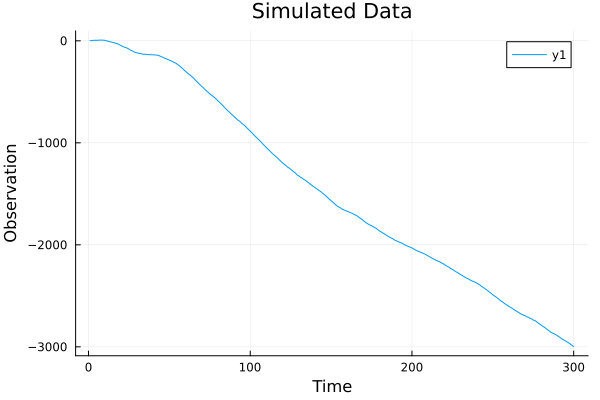

In [155]:
# Define initial state and covariance
state_dim = 4
alpha_init = zeros(state_dim)
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

# True parameters for simulation
psi1 = 0.6
psi2 = 0.2
sigma_xi2 = 0.8
sigma_kappa2_0 = 0.5
sigma_kappa2_1 = 1.2
sigma_epsilon2_0 = 0.4
sigma_epsilon2_1 = 1.1
omega = -0.6
p = 0.3
q = 0.3
params_true = [psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q]

n_obs = 300  # Number of observations

# Simulate data
y, alpha = simulate_data(params_true, n_obs, alpha_init)


plot(y, title="Simulated Data", xlabel="Time", ylabel="Observation")




In [156]:
# Run MCMC initialization
chain_init_burned, Sigma, acceptance_rate_init = initialize_mcmc(
    y,
    alpha_init, 
    P1; 
    n_init=10000, 
    burn_init=5000, 
    omega_init=0.03)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:55


Initialization Acceptance Rate: 46.61 %


([-0.8975937324932891 -2.059928828992874 … 2.499855018126014 -1.7299027504478075; -0.8975937324932891 -2.059928828992874 … 2.499855018126014 -1.7299027504478075; … ; -0.2891810518259606 -2.6775026700692774 … -3.6018196145357493 -2.25450747035663; -0.3695660857955488 -2.608421364617139 … -3.7643694685857407 -2.4648119134142994], [1.213492644589999 0.3423337619282953 … -0.14892880992744723 -0.31541888932968265; 0.3423337619282953 0.6418293780090797 … 0.4671582012402071 -0.1562578646807282; … ; -0.14892880992744723 0.4671582012402071 … 2.6812218165024455 -0.17231254252434758; -0.31541888932968265 -0.1562578646807282 … -0.17231254252434758 1.5555810329978172], 0.4661)

In [157]:
# Run MCMC recursion
theta_samples_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, 
    alpha_init, 
    P1, 
    chain_init_burned, 
    Sigma; 
    n_rec=10000, 
    burn_rec=5000, 
    omega_rec=0.06)


Recursion Phase 100%|████████████████████████████████████| Time: 0:01:24


Recursion Acceptance Rate: 62.96000000000001 %


([0.405993601806237 0.5453635609645278 … 0.5140676538376667 0.5304539601547815; 0.405993601806237 0.5453635609645278 … 0.5140676538376667 0.5304539601547815; … ; 0.4958559150600293 0.2646289593342429 … 0.5907818216941403 0.5898739795714584; 0.4950440534842137 0.19430326630675115 … 0.5126773990308299 0.5652004862570649], Any[[1.3028498461723697 0.6486101754963214 -0.1011047352900584 0.2504228625622186; 2.479930446471259 1.0232861784974632 -0.29714891317045367 -0.24838107610051188; … ; -2976.97382310565 -11.44550543425507 -8.632939415180047 -8.69232919865351; -2989.1608386259954 -11.89897951923518 -8.655087650353448 -8.433933278962478], [1.298571695172319 0.6458870982370452 -0.0968265842900074 0.26222602937343675; 2.481437209864419 1.0309597065794862 -0.2986556765636134 -0.24040175652774545; … ; -2977.1533197389444 -11.43851208399905 -8.453442781885508 -8.518769717528048; -2989.3587314510287 -11.913572113078338 -8.457194825320116 -8.262295739354808], [1.298571695172319 0.6458870982370452

In [158]:


# Number of optimization runs
num_runs = 1

# Parameter names to associate with priors
parameters = ["psi1", "psi2", "sigma_xi2", "sigma_kappa2_0", "sigma_kappa2_1",
              "sigma_epsilon2_0", "sigma_epsilon2_1", "omega", "p", "q"]

upper_bounds = [1.0, 1.0, Inf, Inf, Inf, Inf, Inf, Inf, 1.0, 1.0]
lower_bounds = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -Inf, 0.0, 0.0]

              
# Function to generate initial parameters from specified priors
function draw_initial_params(parameters)
    initial_params = Float64[]  # Enforce Float64 type for the parameters
    for param in parameters
        if param == "psi1"
            # Uniform prior between 0 and 0.999
            push!(initial_params, rand(Uniform(0.001, 0.999)))
        elseif param == "psi2"
            # Uniform prior between 0 and π
            push!(initial_params, rand(Uniform(0.001, 0.99)))
        elseif param in ["p", "q"]
            # Uniform prior between 0 and 1
            push!(initial_params, rand(Uniform(0.01, 0.99)))
        elseif param == "omega"
            # Normal prior with mean -0.5 and std 0.1
            push!(initial_params, rand(Normal(-0.5, 0.5)))
        else
            # Inverse-Gamma prior
            push!(initial_params, rand(InverseGamma(3, 1)))
        end
    end
    return initial_params
end

# Define the objective function
function obj(params::Vector, grad::Vector)
    try
        return neg_log_likelihood(params, y, alpha_init, P1)
    catch e
        return 1e10  # Return a large number in case of error
    end
end

# Run optimization with multiple initial guesses

best_minf = Inf
best_params = nothing

pb = Progress(num_runs; desc="MLE Optimization")
for run in 1:num_runs
    
    # Draw a new set of initial parameters from priors
    initial_params = draw_initial_params(parameters)

    # Create the optimizer
    opt = Opt(:LN_NELDERMEAD, length(initial_params))
    opt.lower_bounds = lower_bounds
    opt.upper_bounds = upper_bounds
    opt.min_objective = obj
    opt.maxeval = 1000
    opt.xtol_rel = 1e-6

    # Run the optimization
    (minf, estimated_params, ret) = NLopt.optimize(opt, initial_params)
 
    # Save the best result
    if minf < best_minf
        best_minf = minf
        best_params = estimated_params
    end

    next!(pb)
end


# Display the best estimated parameters
println("Best Estimated Parameters: ", best_params)


Best Estimated Parameters: [0.4022307992396859, 0.15246378525925178, 1.0279661668605682, 1.3777924374181785, 0.0006869111341481932, 0.2984275489398438, 1.1412014469946545, 1.0699277340733262, 0.6354655959323908, 0.004478480094837826]


In [159]:
parameters = ["psi1", "psi2", "sigma_xi2", "sigma_kappa2_0", "sigma_kappa2_1",
              "sigma_epsilon2_0", "sigma_epsilon2_1", "omega", "p", "q"]

n_params = length(parameters)

10

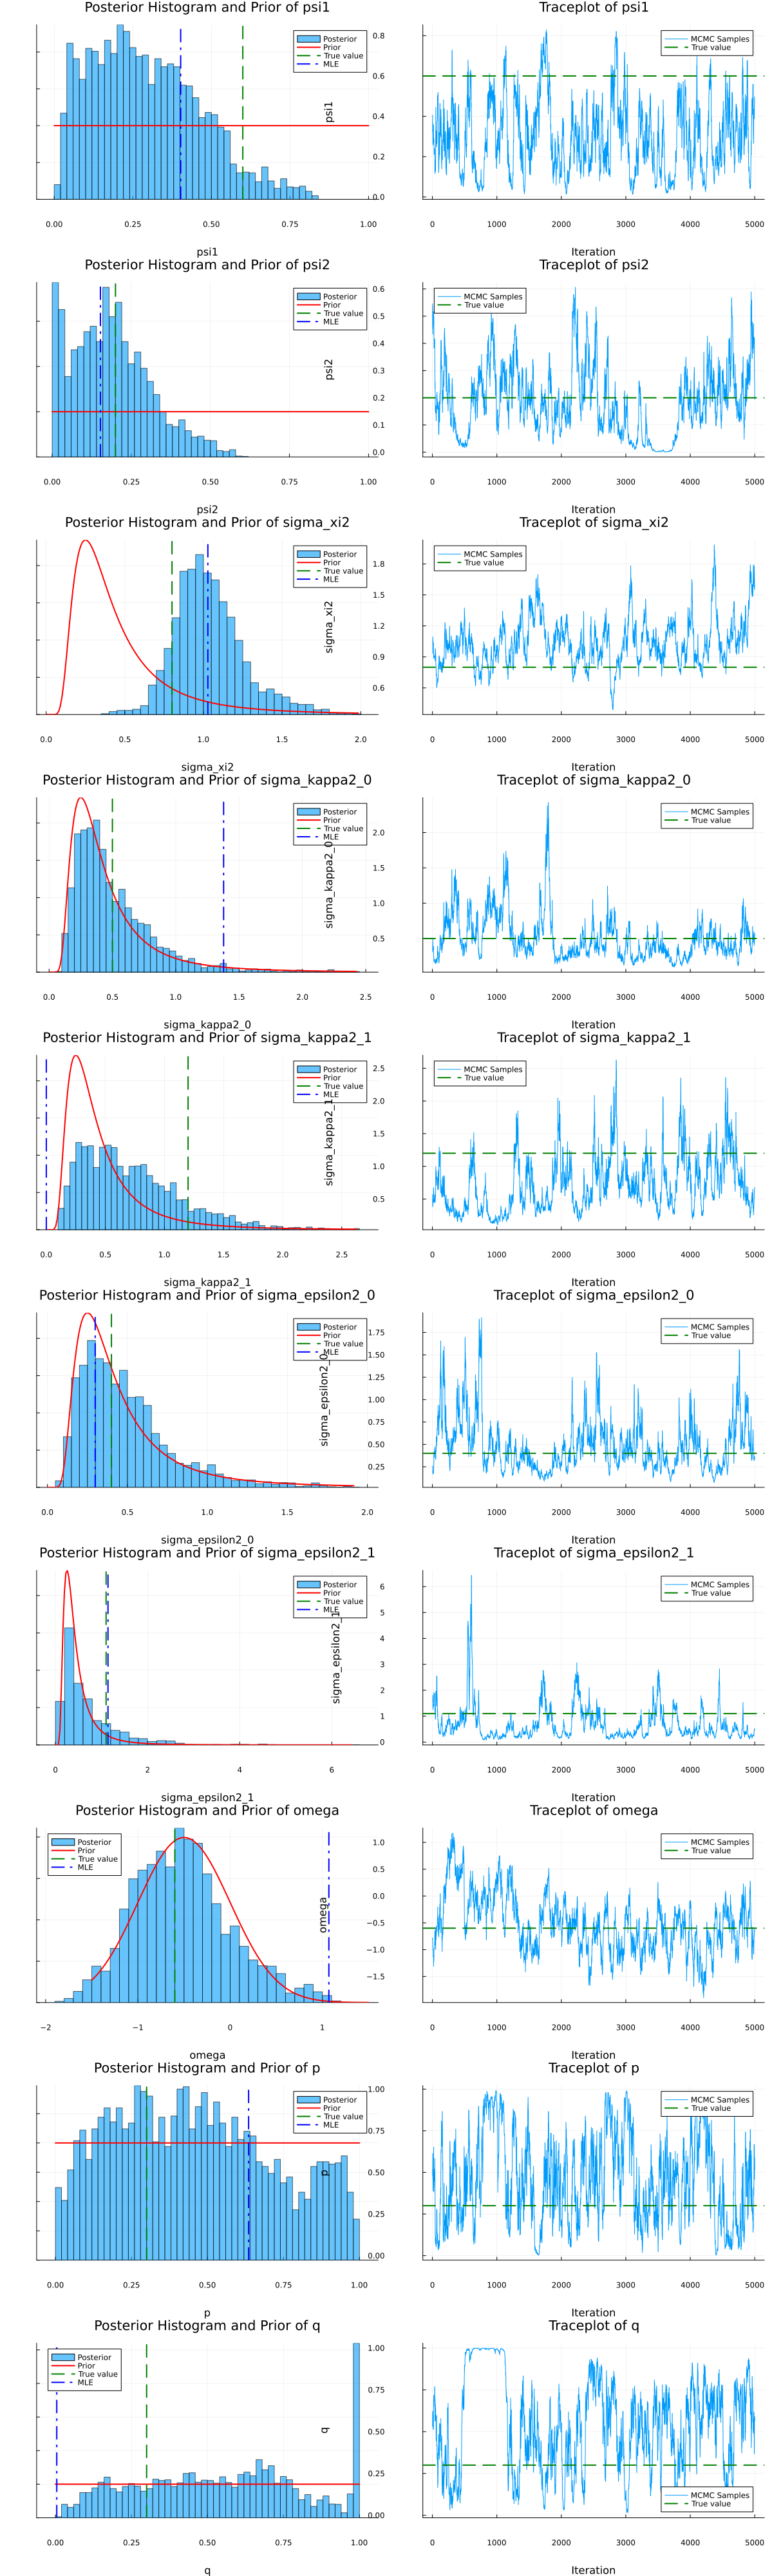

In [160]:
# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples = theta_samples_burned[:, i]
    
    # Histogram of posterior samples
    p1 = histogram(param_samples, bins=50, normalize=true, alpha=0.6,
                   label="Posterior", xlabel=parameters[i], ylabel="Density",
                   title="Posterior Histogram and Prior of $(parameters[i])")
    
    # Define the prior distribution
    if parameters[i] == "psi1"
        # Uniform prior between 0 and 0.999
        a = 0.0
        b = 1
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] == "psi2"
        # Uniform prior between 0 and π
        a = 0.0
        b = 1
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] in ["p", "q"]
        # Uniform prior between 0 and 1
        a = 0.0
        b = 1.0
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] == "omega"
        # Normal prior with mean -0.5 and std 1
        x_values = range(-1.5, 1.5, length=200)
        prior_pdf = pdf.(Normal(-0.5, 0.5), x_values)
    else
        # Inverse-Gamma prior with a=3, b=1
        a_ig = 3.0
        b_ig = 1.0
        x_min = 0.001  # Avoid zero
        x_max = maximum(param_samples)
        x_values = range(x_min, x_max, length=200)
        prior_pdf = pdf.(InverseGamma(a_ig, b_ig), x_values)
    end
    
    # Overlay prior PDF on histogram
    plot!(p1, x_values, prior_pdf, label="Prior", color=:red, linewidth=2)
    
    # Include true parameter value
    vline!(p1, [params_true[i]], label="True value", color=:green, linestyle=:dash, linewidth=2)
    
    # If you have MLE estimates, include them (uncomment and define `estimated_params`)
    vline!(p1, [best_params[i]], label="MLE", color=:blue, linestyle=:dashdot, linewidth=2)
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")
    hline!(p2, [params_true[i]], label="True value", color=:green, linestyle=:dash, linewidth=2)
    
    # Add plots to the list
    push!(p_list, p1)
    push!(p_list, p2)
end

# Display the plots in a grid layout
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [161]:
# Calculate means of posterior samples
chain_rec_burned_means = mean(theta_samples_burned, dims=1)  # 1 x n_params array
chain_rec_burned_means = vec(chain_rec_burned_means)  # Convert to a vector


10-element Vector{Float64}:
  0.2943528183599156
  0.187107006950496
  1.038847977201106
  0.5062593733200678
  0.7214713596976654
  0.48901252396780404
  0.7021425223330392
 -0.5150828591621283
  0.46085430966029434
  0.5473488589845985

In [162]:

# Create the DataFrame
data = DataFrame(Dict(
    "Parameter" => parameters,
    "MCMC Estimate" => chain_rec_burned_means,
    "MLE Estimate" => best_params,  # Include if available
    "True Value" => params_true
))

# Display the DataFrame
display(data)


10×4 DataFrame
 Row │ MCMC Estimate  MLE Estimate  Parameter         True Value 
     │ Float64        Float64       String            Float64    
─────┼───────────────────────────────────────────────────────────
   1 │      0.294353   0.402231     psi1                     0.6
   2 │      0.187107   0.152464     psi2                     0.2
   3 │      1.03885    1.02797      sigma_xi2                0.8
   4 │      0.506259   1.37779      sigma_kappa2_0           0.5
   5 │      0.721471   0.000686911  sigma_kappa2_1           1.2
   6 │      0.489013   0.298428     sigma_epsilon2_0         0.4
   7 │      0.702143   1.1412       sigma_epsilon2_1         1.1
   8 │     -0.515083   1.06993      omega                   -0.6
   9 │      0.460854   0.635466     p                        0.3
  10 │      0.547349   0.00447848   q                        0.3

(4981,)

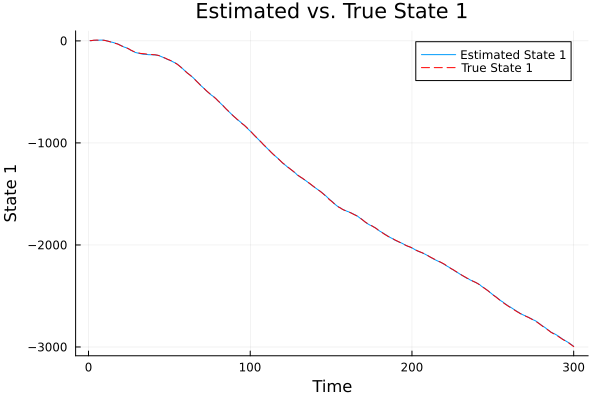

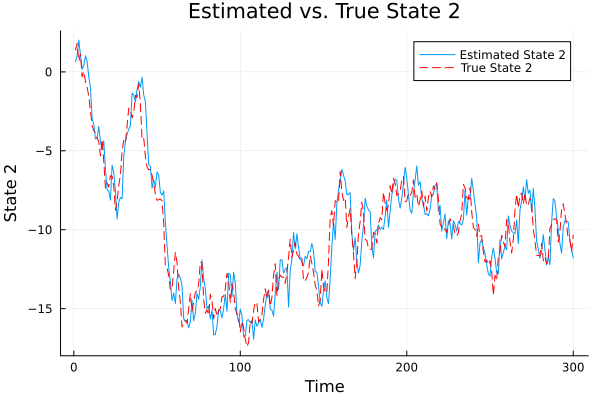

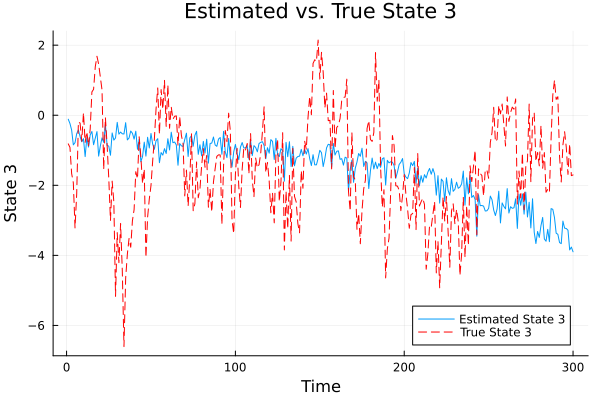

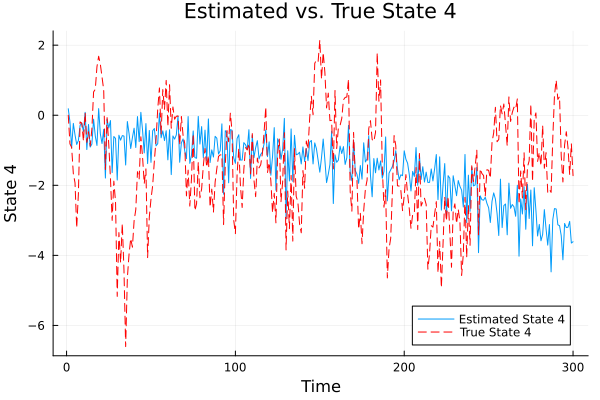

In [163]:

#discard first 20 alpha samples
alpha_samples_cut = alpha_samples[21:end]
print(size(alpha_samples_cut))
n_samples = length(alpha_samples_cut)
n_time_steps = size(alpha_samples_cut[1], 1)
state_dim = size(alpha_samples_cut[1], 2)

# Initialize array to hold alpha samples
alpha_samples_array = Array{Float64}(undef, n_samples, n_time_steps, state_dim)
# Collect alpha samples into a 3D array
for i in 1:n_samples
    alpha_samples_array[i, :, :] = alpha_samples_cut[i]
end



# Compute posterior mean over samples (dimension 1)
alpha_mean = mean(alpha_samples_array, dims=1)  # 1 x n_time_steps x state_dim
alpha_mean = dropdims(alpha_mean; dims=1)  # n_time_steps x state_dim

# Compute credible intervals
alpha_lower = mapslices(x -> quantile(x, 0.025), alpha_samples_array; dims=1)
alpha_lower = dropdims(alpha_lower; dims=1)
alpha_upper = mapslices(x -> quantile(x, 0.975), alpha_samples_array; dims=1)
alpha_upper = dropdims(alpha_upper; dims=1)



time = 1:n_time_steps

for s in 1:state_dim
    p = plot(time, alpha_mean[:, s], label="Estimated State $(s)", xlabel="Time",
             ylabel="State $(s)", title="Estimated vs. True State $(s)")
    
    # Add credible intervals using the `ribbon` argument
    # plot!(time, alpha_mean[:, s], ribbon=(alpha_mean[:, s] .- alpha_lower[:, s],
    #       alpha_upper[:, s] .- alpha_mean[:, s]), fillalpha=0.3, label="95% Credible Interval")
    
    # Plot true state (assuming you have `alpha_true` from data simulation)
    plot!(time, alpha[1:n_time_steps, s], label="True State $(s)", linestyle=:dash, color=:red)
    
    display(p)
end


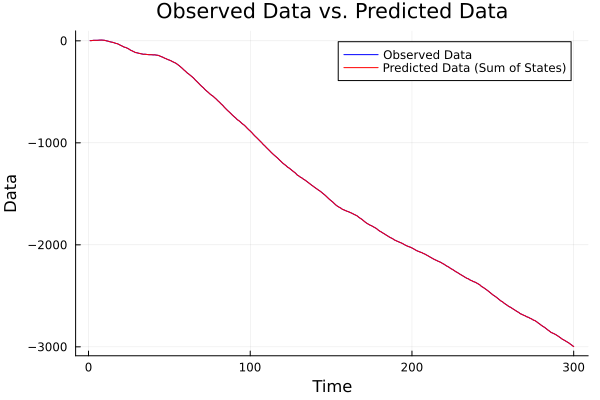

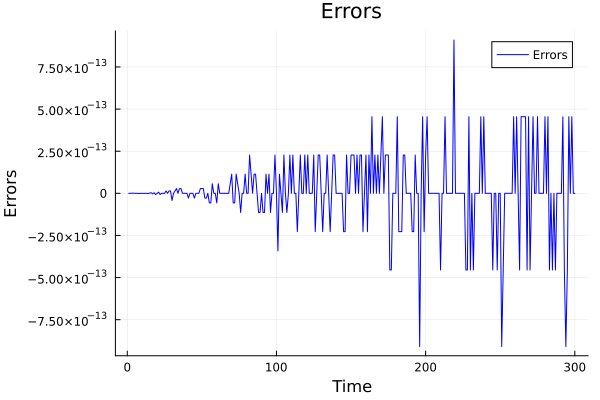

In [164]:
# Compute y_pred
state_indices = [1, 3]  # Adjust as necessary

y_pred = alpha_mean[:, state_indices[1]] .+ alpha_mean[:, state_indices[2]]

time = 1:length(y_pred)
y_adjusted = y[1:length(y_pred)]  # Adjust if lengths differ

p = plot(time, y_adjusted, label="Observed Data", color=:blue)
plot!(p, time, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Data")
display(p)


errors = y_adjusted .- y_pred

p_error = plot(time, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)


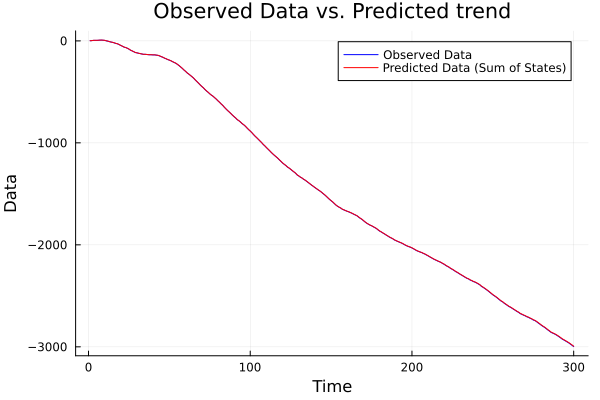

In [165]:
# estimated state 1 and true observation y
# Compute y_pred
state_indices = [1, 3]  # Adjust as necessary

y_pred = alpha_mean[:, state_indices[1]] 

time = 1:length(y_pred)
y_adjusted = y[1:length(y_pred)]  # Adjust if lengths differ

p = plot(time, y_adjusted, label="Observed Data", color=:blue)
plot!(p, time, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted trend")
display(p)



